In [20]:
import time
import pandas as pd
from IPython.display import display_html
from matplotlib import pyplot as plt

## download model

In [21]:
%pip install gdown

import gdown
import os

model_path = os.path.abspath("../models/frozen_east_text_detection.pb")

if not os.path.exists(model_path):
    os.makedirs(os.path.dirname(model_path), exist_ok=True)
    url = 'https://drive.google.com/uc?id=14n9TxYnnYT26Q_-xAmWOkQkKfdjiP8bN'
    gdown.download(url, model_path, quiet=False)

Note: you may need to restart the kernel to use updated packages.


## load image

In [22]:
import numpy as np
import os
import PIL
from PIL import Image, ImageOps
PIL.Image.MAX_IMAGE_PIXELS = 933120000

cached_img_load = {}

def get_files(name,path):
    if not os.path.isdir(path):
        return [(name,path)]
    else:
        targets = [
            f for f in os.listdir(path) if not os.path.isdir(os.path.join(path, f))
        ]
        return [
            (name + '/' + f, os.path.join(path, f)) for f in targets
        ]

def load_image(name,path):
    try:
        image = Image.open(path)
        # https://stackoverflow.com/questions/63947990/why-are-width-and-height-of-an-image-are-inverted-when-loading-using-pil-versus
        image = ImageOps.exif_transpose(image)

        img = np.array(image.convert('RGB'))
        dpi = image.info.get("dpi")

        print("name: ", name, 'dpi:', dpi)

        cached_img_load[name] = (img,dpi)
    except Exception as e:
        print("skip: ", path)

In [23]:
files = get_files("images", os.path.abspath("../images/east-model"))
for n,f in files:
    load_image(n,f)

name:  images/9oxSmS8RlOgaDiYmJsqAhA.left_half.png dpi: None


## load model

In [24]:
import cv2

# load the pre-trained EAST text detector
net = cv2.dnn.readNet(model_path)

print('model:', model_path)

model: f:\code\@cv\awesome-text-deskew\models\frozen_east_text_detection.pb


## preprocess image

name:  images/9oxSmS8RlOgaDiYmJsqAhA.left_half.png time:  0.000000 seconds


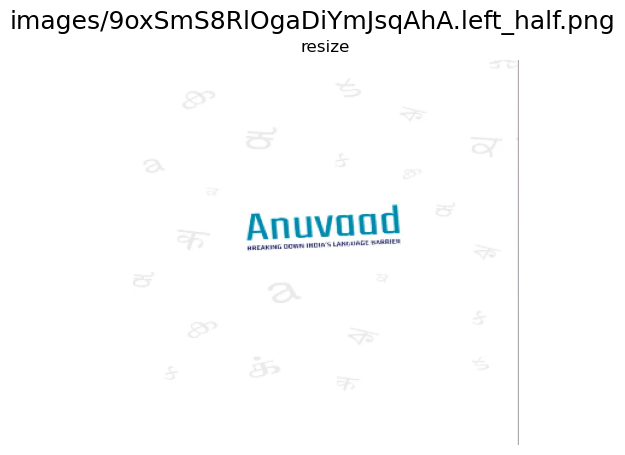

In [25]:
import cv2
from skimage.feature import canny

cached_img_preprocess = {}

for name,(img,_) in cached_img_load.items():
    start = time.time()

    (H, W) = img.shape[:2]

    width = 320
    height = 320

    (newW, newH) = (width, height)
    rW = W / float(newW)
    rH = H / float(newH)

    image = cv2.resize(img, (newW, newH))

    end = time.time()
    cached_img_preprocess[name] = image


    print("name: ", name, "time: ", "{:.6f} seconds".format(end - start))

    # show the output image
    imgs_show = [
        ("resize", image),
    ]
    fig = plt.figure(figsize=(10,5))
    fig.suptitle(name, fontsize=18)
    gs = fig.add_gridspec(1,len(imgs_show))
    for idx, (name,img) in enumerate(imgs_show):
        if img is None: continue
        ax = fig.add_subplot(gs[0, idx])
        ax.set_title(name)
        ax.axis('off')
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

## forward score

In [26]:
cached_score_forward = {}

for name,img in cached_img_preprocess.items():
    start = time.time()

    (H, W) = img.shape[:2]
    blob = cv2.dnn.blobFromImage(img, 1.0, (W, H),
            (123.68, 116.78, 103.94), swapRB=True, crop=False)

    net.setInput(blob)

    layerNames = [
        "feature_fusion/Conv_7/Sigmoid",
        "feature_fusion/concat_3"
    ]
    (scores, geometry) = net.forward(layerNames)


    end = time.time()
    cached_score_forward[name] = (scores, geometry)


    print("name: ", name, "time:", "{:.6f} seconds".format(end - start))

name:  images/9oxSmS8RlOgaDiYmJsqAhA.left_half.png time: 0.193568 seconds


## median angle

In [27]:
cached_angle_median = {}

for name,(scores, geometry) in cached_score_forward.items():
    start = time.time()

    # 
    min_confidence = 0.5

    # 
    (numRows, numCols) = scores.shape[2:4]
    angl = []

    for y in range(0, numRows):
        
        scoresData = scores[0, 0, y]
        anglesData = geometry[0, 4, y]

        for x in range(0, numCols):
            if scoresData[x] < min_confidence:
                continue
            
            angle = anglesData[x]
            angl.append(angle*180/(np.pi))

    angle = np.median(angl)
    skew_angle = -angle

    end = time.time()
    cached_angle_median[name] = skew_angle


    print("name: ", name, "time: ", "{:.6f} seconds".format(end - start))
    
    df1 = pd.DataFrame.from_dict({
        'angles': angl
    })
    df1_styler = df1.style.set_table_attributes("style='display:inline'")
    df1_styler.set_caption(f"peak {len(angl)} use angle: {angle}")
    display_html(df1_styler._repr_html_(), raw=True)

name:  images/9oxSmS8RlOgaDiYmJsqAhA.left_half.png time:  0.004000 seconds


,angles
0,7.379046
1,7.374347
2,2.807607
3,2.698051
4,3.498433
5,2.356217
6,3.216801
7,2.997405
8,2.981173
9,2.204877


## deskew image

name:  images/9oxSmS8RlOgaDiYmJsqAhA.left_half.png time:  0.001000 seconds


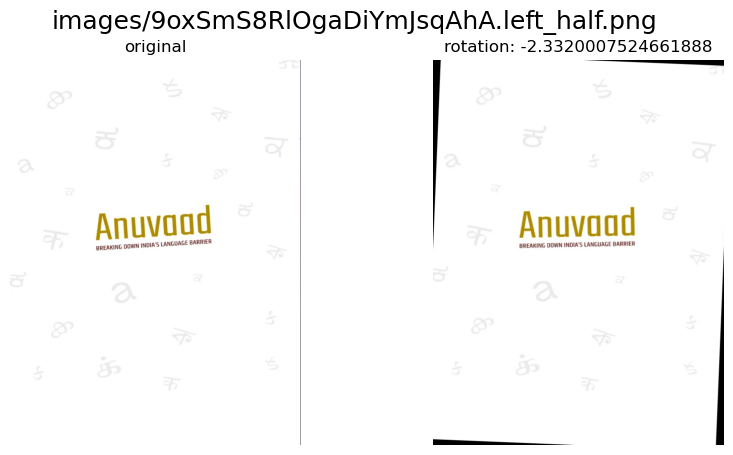

In [28]:
for name,angle in cached_angle_median.items():
    start = time.time()

    img,_ = cached_img_load[name]

    # Rotate original image
    img_center = tuple(np.array(img.shape[1::-1]) / 2)
    rotation_matrix = cv2.getRotationMatrix2D(img_center, angle, 1.0)
    img_rotated = cv2.warpAffine(img, rotation_matrix, img.shape[1::-1], flags=cv2.INTER_LINEAR)

    end = time.time()


    print("name: ", name, "time: ", "{:.6f} seconds".format(end - start))

    # show the output image
    imgs_show = [
        ("original", img),
        (f"rotation: {angle}", img_rotated)
    ]
    fig = plt.figure(figsize=(10,5))
    fig.suptitle(name, fontsize=18)
    gs = fig.add_gridspec(1,len(imgs_show))
    for idx, (name,img) in enumerate(imgs_show):
        ax = fig.add_subplot(gs[0, idx])
        ax.set_title(name)
        ax.axis('off')
        ax.imshow(img)
